In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import emcee
from scipy.special import hyp2f1
from scipy.integrate import quad
from scipy.special import gamma
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'mathtext.default':'regular'})
plt.rcParams.update({'mathtext.fontset':'stixsans'})
plt.rcParams.update({'axes.linewidth': 1.5})
plt.rcParams.update({'xtick.direction':'in'})
plt.rcParams.update({'xtick.major.size': 5})
plt.rcParams.update({'xtick.major.width': 1.25 })
plt.rcParams.update({'xtick.minor.size': 2.5})
plt.rcParams.update({'xtick.minor.width': 1.25 })
plt.rcParams.update({'ytick.direction':'in'})
plt.rcParams.update({'ytick.major.size': 5})
plt.rcParams.update({'ytick.major.width': 1.25 })
plt.rcParams.update({'ytick.minor.size': 2.5})
plt.rcParams.update({'ytick.minor.width': 1.25 })

Text(0, 0.5, 'N Clouds')

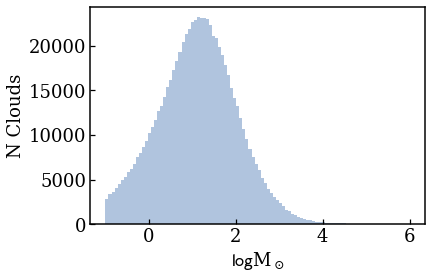

In [2]:
os.chdir("/Users/helenarichie/GitHub/ASTR-3705-Class-Project/src/")

res512, res1024, res2048 = np.load("../data/masses.npy", allow_pickle=True)

def cell_vol_kpc(res):
    return (10.0 / float(res)) ** 3

res = 2048
colors = "lightsteelblue"
fcolors = "indianred"
masses = res2048 * cell_vol_kpc(res)
xmin = 0.1
massind = np.where(masses > xmin)
masses1 = masses[massind]

nbins = 100

n2048, bins2048, patches2048 = plt.hist(np.log10(masses1), bins=nbins, color=colors, label=r"$R={2048}$")
plt.xlabel("$\log M_\odot$")
plt.ylabel("N Clouds")

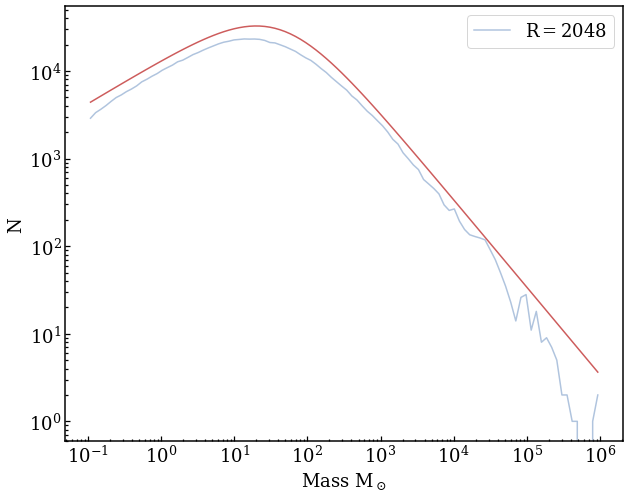

In [3]:
a1 = -0.5
a2 = 1
mpeak = 40
delta = 1
A = 3e4

center_mass = (10 ** bins2048[1:] + 10 ** bins2048[:-1]) / 2.

fm = A * (center_mass / mpeak) ** (-a1) * (0.5 * (1 + (center_mass / mpeak) ** (1 / delta))) ** ((a1 - a2) / delta)

fig = plt.figure(figsize=(10, 8))
plt.plot(center_mass, n2048, label=f"$R={res}$", color=colors)
plt.plot(center_mass, fm, color=fcolors)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mass$~M_\odot$")
plt.ylabel("N")
plt.legend()
plt.show()

# ML using MCMC

In [4]:
def model(mass, theta):
    """Broken power law model with 4 free parameters used to model the
    behavior of the cloud mass probability distribution.
    """
    mpeak, a1, a2, delta = theta
    return (mass / mpeak) ** (-a1) * (0.5 * (1 + (mass / mpeak) ** (1 / delta))) ** ((a1 - a2) * delta)

def bpl_analytic(theta, m):
    mpeak, a1, a2, delta = theta
    coeff1 = 2 ** ((a2 - a1) * delta)
    coeff2 = (m / mpeak) ** (1 - a1)
    coeff3 = m + mpeak
    coeff4 = (((m + mpeak) / mpeak) ** (1 / delta)) ** ((a1 - a2) * delta)
    coeff = coeff1 * coeff2 * coeff3 * coeff4 * gamma(1 - a1)
    return coeff * hyp2f1(1, 2 - a2, 2 - a1, -(m / mpeak))

def lnlike(theta, mass, xmin):
    """Compute the likelihood of the data given the model.
    """
    mpeak, a1, a2, delta = theta
    # calculate broken power-law model for the current set of parameters
    mod = model(mass, theta)
    A = quad(model, xmin, 10 ** 4, args=theta)[0]
    # A = bpl_analytic(theta, mass)
    likenorm = mod / A
    # calculate the likelihood
    likelihood = np.sum(np.log(likenorm))
    if not np.isfinite(likelihood):
            return -np.inf
    return likelihood

a1low, a1up = -3, -0.01
a2low, a2up = 0.01, 3
mpeaklow, mpeakup = 5, 100
deltalow, deltaup = 0.1, 5
def lnprior(theta):
    mpeak, a1, a2, delta = theta
    if not np.logical_and(a1 >= a1low, a1 <= a1up):
        return -np.inf
    if not np.logical_and(a2 >= a2low, a2 <= a2up):
        return -np.inf
    if not np.logical_and(mpeak >= mpeaklow, mpeak <= mpeakup):
        return -np.inf
    if not np.logical_and(delta >= deltalow, delta <= deltaup):
        return -np.inf
    # assume a flat prior 
    return 0.0

def lnprob(theta, mass, xmin):
    mpeak, a1, a2, delta = theta
    lp = lnprior(theta)
    if not np.isfinite(lp):
            return -np.inf
    return lp + lnlike(theta, mass, xmin)

In [5]:
data = (masses1, xmin)
nwalkers = 20
niter = 100
theta0 = np.array([mpeak, a1, a2, delta])
ndim = len(theta0)
p0 = [np.array(theta0) * (1 + 0.1 * np.random.randn(ndim)) for i in range(nwalkers)]

In [6]:
def main(p0, nwalkers, niter, ndim, lnprob, data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

In [7]:
sampler, pos, prob, state = main(p0, nwalkers, niter, ndim, lnprob, data)

Running burn-in...
Running production...


In [8]:
def plotter(sampler, mass=center_mass, n=n2048):
    fig = plt.figure(figsize=(10, 8))
    data_norm = n2048 / np.sum(n2048)
    plt.loglog(mass, n2048, label="Data", color="k")
    samples = sampler.flatchain
    # bin width in solar masses
    dM = (10 ** bins2048[1:] - 10 ** bins2048[:-1])
    mpeaks = []
    a1s = []
    a2s = []
    deltas = []
    for theta in samples[np.random.randint(len(samples), size=1000)]:
        pM = model(mass, theta)
        A = quad(model, xmin, 10 ** 4, args=theta)[0]
        expectation_value = pM * np.sum(n2048) * dM / A
        plt.loglog(mass, expectation_value, c="r", alpha=0.1, zorder=0)
        mpeaks.append(theta[0])
        a1s.append(theta[1])
        a2s.append(theta[2])
        deltas.append(theta[3])
    plt.plot(0, label="MCMC", color="r")
    plt.legend()
    plt.xlabel("Mass$~[M_\odot]$")
    plt.ylabel("N")
    plt.show()

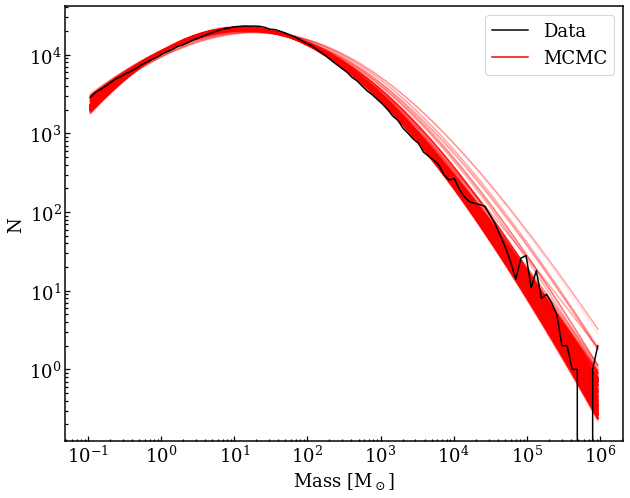

In [9]:
plotter(sampler)

# ML using scipy.optimize.minimize

In [10]:
from scipy.optimize import minimize

In [15]:
def minus_lnprob(theta, mass=masses1, xmin=xmin):    
    mpeak, a1, a2, delta = theta
    lp = lnprior(theta)
    if not np.isfinite(lp):
            return -np.inf
    return -(lp + lnlike(theta, mass, xmin))

In [16]:
params = minimize(minus_lnprob, theta0, bounds=((mpeaklow, mpeakup), 
                                                (a1low, a1up), 
                                                (a2low, a2up), 
                                                (deltalow, deltaup)), 
                  args=(masses1, xmin))
print(params)

      fun: 3408171.5773852635
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.19095124e-01, -3.37837264e+03, -1.93249435e+01, -1.30385161e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 105
      nit: 19
     njev: 21
   status: 0
  success: True
        x: array([ 2.23466445e+01, -1.00000000e-02,  2.26400056e+00,  2.30364451e+00])


In [20]:
def ML_plotter(params, mass=center_mass, n=n2048):
    fig = plt.figure(figsize=(10, 8))
    data_norm = n2048 / np.sum(n2048)
    plt.loglog(mass, n2048, label="Data", color="k")
    samples = sampler.flatchain
    # bin width in solar masses
    dM = (10 ** bins2048[1:] - 10 ** bins2048[:-1])
    theta = params.x
    pM = model(mass, theta)
    A = quad(model, xmin, 10 ** 4, args=theta)[0]
    expectation_value = pM * np.sum(n2048) * dM / A
    plt.loglog(mass, expectation_value, c="r")
    plt.plot(0, label="ML", color="r")
    plt.legend()
    plt.xlabel("Mass$~[M_\odot]$")
    plt.ylabel("N")
    plt.show()

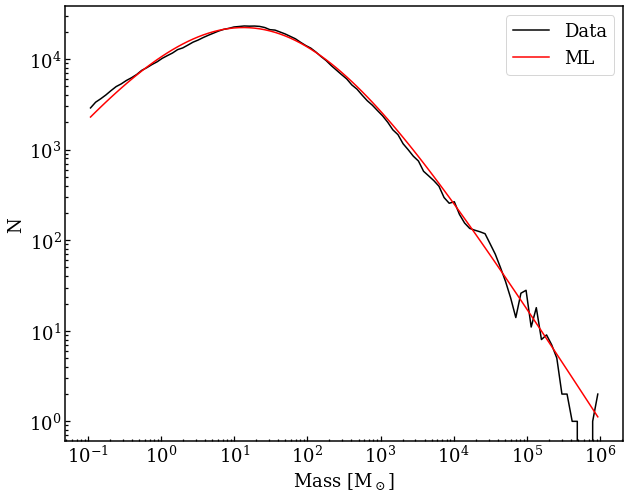

In [21]:
ML_plotter(params)